# Analyzing Urban Air Quality: A Data-Driven Study of PM2.5 Levels in Beijing

## DATA CLEANING & PRE-PROCESSING

In [2]:
#Importing Libraries and Loading Dataset
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\HP PC\Downloads\beijing+pm2+5+data\PRSA_data_2010.1.1-2014.12.31.csv")
df.head()



,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Shape of dataset
print("Shape:", df.shape)

# Info
df.info()

# Missing values
df.isnull().sum()

Shape: (43824, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

# Handling Missing Values

In [4]:
# Meteorological values interpolation
numeric_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

# Median imputation for PM2.5
df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].median())

# Forward + backward fill for any small remaining gaps
df = df.ffill().bfill()

df.isnull().sum()

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

# Handling Duplicate Row

In [5]:
print("Duplicates:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

Duplicates: 0
After removing duplicates: (43824, 13)


### Fixing Date-Time Format

In [6]:
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

# Optional: remove original columns
df = df.drop(columns=['year','month','day','hour'])

df.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,72.0,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,72.0,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,72.0,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,72.0,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,72.0,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


### Cleaning Categorical Values (Wind Direction)

In [7]:
df['cbwd'] = df['cbwd'].replace({'cv': 'Calm'})
df['cbwd'] = df['cbwd'].astype('category')
df['cbwd'].unique()

['NW', 'Calm', 'NE', 'SE']
Categories (4, object): ['Calm', 'NE', 'NW', 'SE']

### Time-based features

In [8]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

### Season feature

In [9]:
def get_season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

### Pollution Level Categories

In [10]:
def pm_category(pm):
    if pm < 35:
        return 'Good'
    elif pm < 75:
        return 'Moderate'
    elif pm < 115:
        return 'Unhealthy'
    elif pm < 150:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df['pm_level'] = df['pm2.5'].apply(pm_category)

### Rolling Averages (for trend analysis)

In [11]:
# 24-hour rolling mean
df['pm2.5_24h_avg'] = df['pm2.5'].rolling(window=24, min_periods=1).mean()

# 7-day rolling mean
df['pm2.5_7day_avg'] = df['pm2.5'].rolling(window=24*7, min_periods=1).mean()


### Outlier Removal

In [12]:
Q1 = df['pm2.5'].quantile(0.25)
Q3 = df['pm2.5'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['pm2.5'] >= lower) & (df['pm2.5'] <= upper)]
df.shape

(41707, 20)

In [13]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 41707 entries, 0 to 43823
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   No              41707 non-null  int64         
 1   pm2.5           41707 non-null  float64       
 2   DEWP            41707 non-null  int64         
 3   TEMP            41707 non-null  float64       
 4   PRES            41707 non-null  float64       
 5   cbwd            41707 non-null  category      
 6   Iws             41707 non-null  float64       
 7   Is              41707 non-null  int64         
 8   Ir              41707 non-null  int64         
 9   datetime        41707 non-null  datetime64[ns]
 10  year            41707 non-null  int32         
 11  month           41707 non-null  int32         
 12  day             41707 non-null  int32         
 13  hour            41707 non-null  int32         
 14  dayofweek       41707 non-null  int32         
 15  is_week

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,year,month,day,hour,dayofweek,is_weekend,season,pm_level,pm2.5_24h_avg,pm2.5_7day_avg
0,1,72.0,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,2010,1,1,0,4,0,Winter,Moderate,72.0,72.0
1,2,72.0,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,2010,1,1,1,4,0,Winter,Moderate,72.0,72.0
2,3,72.0,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,2010,1,1,2,4,0,Winter,Moderate,72.0,72.0
3,4,72.0,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,2010,1,1,3,4,0,Winter,Moderate,72.0,72.0
4,5,72.0,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,2010,1,1,4,4,0,Winter,Moderate,72.0,72.0


# EDA & Visualizations

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary Statistics of Key Variables
# Summary statistics for numerical variables
df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Iws']].describe()

,pm2.5,TEMP,DEWP,PRES,Iws
count,41707.000000,41707.000000,41707.000000,41707.000000,41707.000000
mean,83.613614,12.834105,1.880644,1016.282519,24.862979
std,65.362113,12.191061,14.620107,10.359533,51.036042
min,0.000000,-19.000000,-40.000000,991.000000,0.450000
25%,29.000000,2.000000,-11.000000,1008.000000,1.790000
50%,72.000000,14.000000,2.000000,1016.000000,5.810000
75%,120.000000,23.000000,16.000000,1025.000000,23.250000
max,283.000000,42.000000,28.000000,1046.000000,585.600000


# UNIVARIATE ANALYSIS

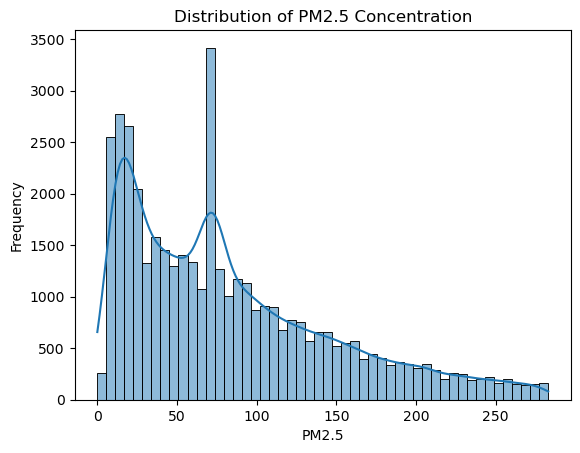

In [34]:
#Distribution of PM2.5 Concentration
plt.figure()
sns.histplot(df['pm2.5'], bins=50, kde=True)
plt.title("Distribution of PM2.5 Concentration")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.show()

### Insight:
PM2.5 values are right-skewed, indicating frequent moderate pollution with occasional extreme pollution events.

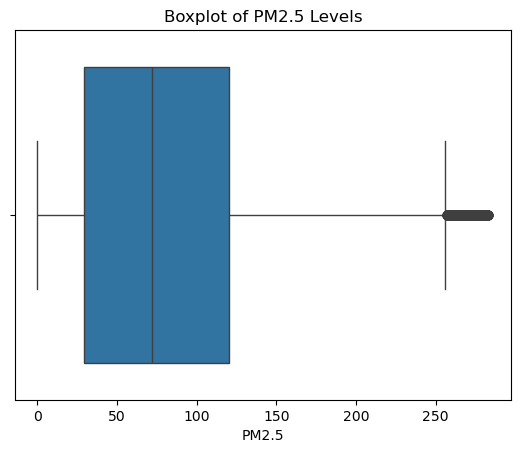

In [37]:
# Box Plot of PM2.5
plt.figure()
sns.boxplot(x=df['pm2.5'])
plt.title("Boxplot of PM2.5 Levels")
plt.xlabel("PM2.5")
plt.show()

### Insight:
Presence of outliers shows occasional hazardous pollution levels.

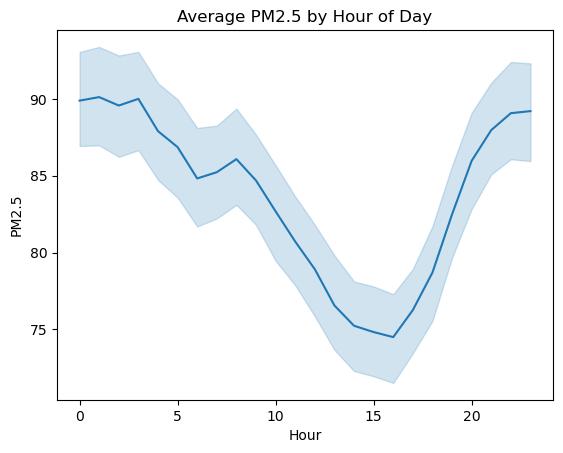

In [20]:
#Hourly Trend of PM2.5
plt.figure()
sns.lineplot(data=df, x='hour', y='pm2.5')
plt.title("Average PM2.5 by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

### Insight:
PM2.5 levels tend to increase during late night and early morning hours.

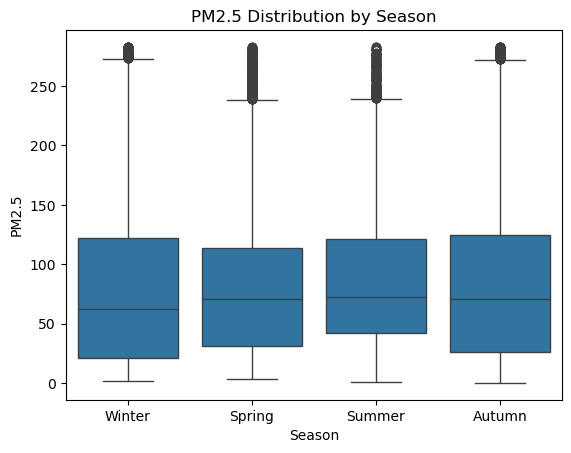

In [21]:
#PM2.5 Levels by Season
plt.figure()
sns.boxplot(data=df, x='season', y='pm2.5')
plt.title("PM2.5 Distribution by Season")
plt.xlabel("Season")
plt.ylabel("PM2.5")
plt.show()

### Insight:
Winter shows the highest pollution levels due to heating activities and weather conditions.

# BIVARIATE ANALYSIS

### PM2.5 vs Temperature

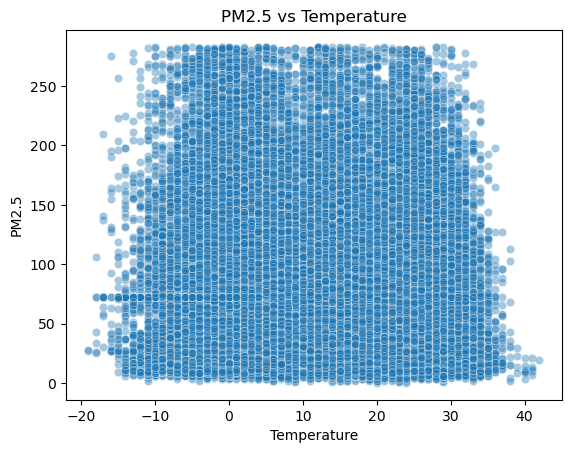

In [23]:
plt.figure()
sns.scatterplot(data=df, x='TEMP', y='pm2.5', alpha=0.4)
plt.title("PM2.5 vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("PM2.5")
plt.show()

### Insight:
Lower temperatures often correspond with higher PM2.5 concentrations.

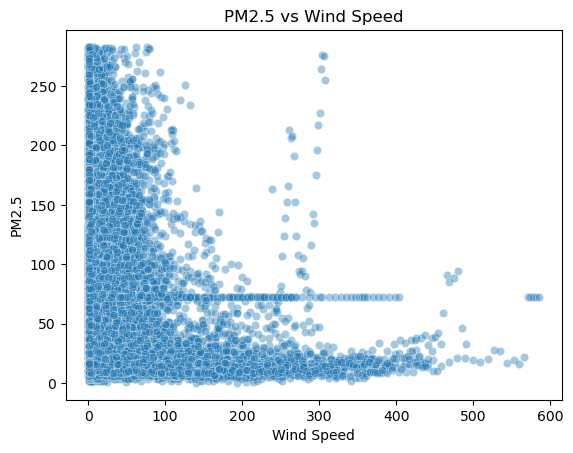

In [24]:
# M2.5 vs Wind Speed (Iws)
plt.figure()
sns.scatterplot(data=df, x='Iws', y='pm2.5', alpha=0.4)
plt.title("PM2.5 vs Wind Speed")
plt.xlabel("Wind Speed")
plt.ylabel("PM2.5")
plt.show()

### Insight:
Higher wind speeds help disperse pollutants, resulting in lower PM2.5 levels.

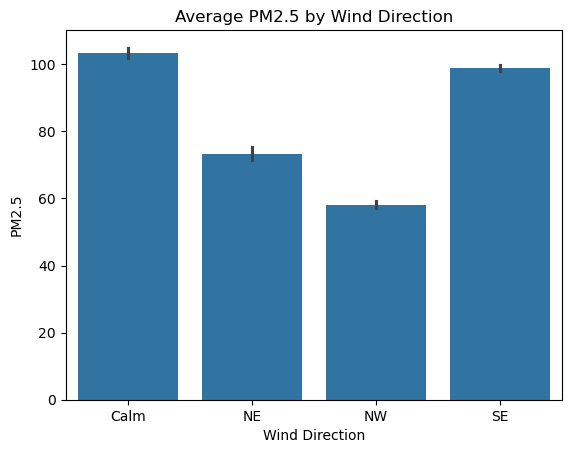

In [25]:
# Average PM2.5 by Wind Direction
plt.figure()
sns.barplot(data=df, x='cbwd', y='pm2.5')
plt.title("Average PM2.5 by Wind Direction")
plt.xlabel("Wind Direction")
plt.ylabel("PM2.5")
plt.show()

### Insight:
Certain wind directions bring more polluted air into the city.

# MULTIVARIATE ANALYSIS

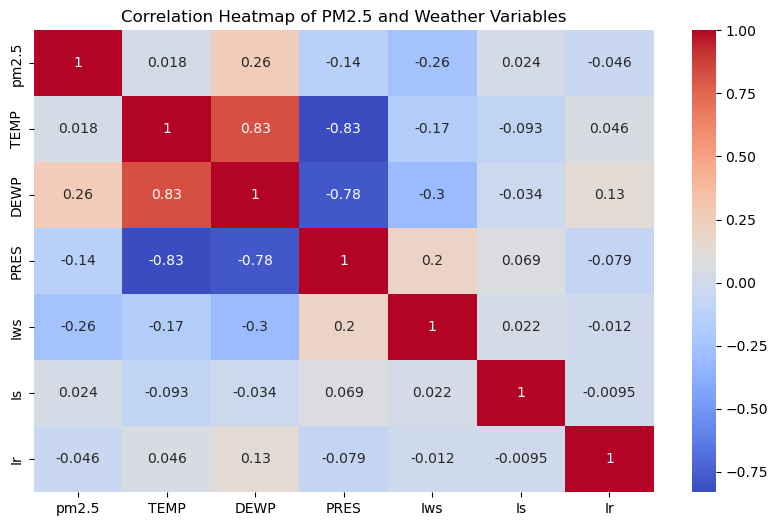

In [27]:
#Correlation Heatmap
plt.figure(figsize=(10,6))
corr = df[['pm2.5','TEMP','DEWP','PRES','Iws','Is','Ir']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of PM2.5 and Weather Variables")
plt.show()


### Insight:
PM2.5 shows:

Positive correlation with pressure and dew point

Negative correlation with wind speed and temperature

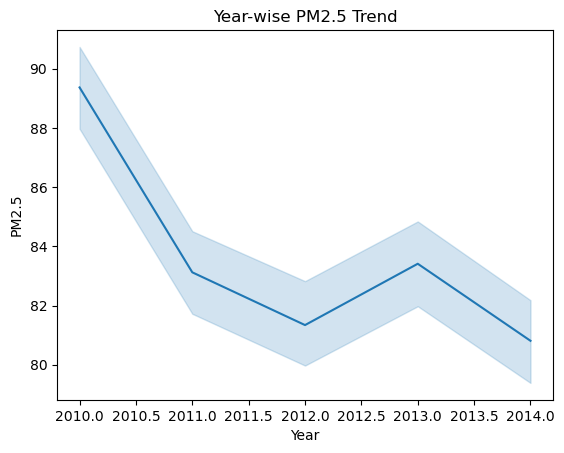

In [28]:
# Year-wise PM2.5 Trend
plt.figure()
sns.lineplot(data=df, x='year', y='pm2.5')
plt.title("Year-wise PM2.5 Trend")
plt.xlabel("Year")
plt.ylabel("PM2.5")
plt.show()


### Insight:
Pollution levels vary across years, showing periods of improvement and deterioration.

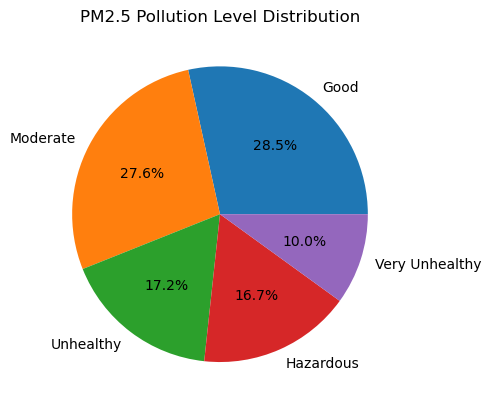

In [29]:
# pollution Category Distribution
plt.figure()
df['pm_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("PM2.5 Pollution Level Distribution")
plt.ylabel("")
plt.show()


### Insight:
Most observations fall under Moderate and Unhealthy categories.

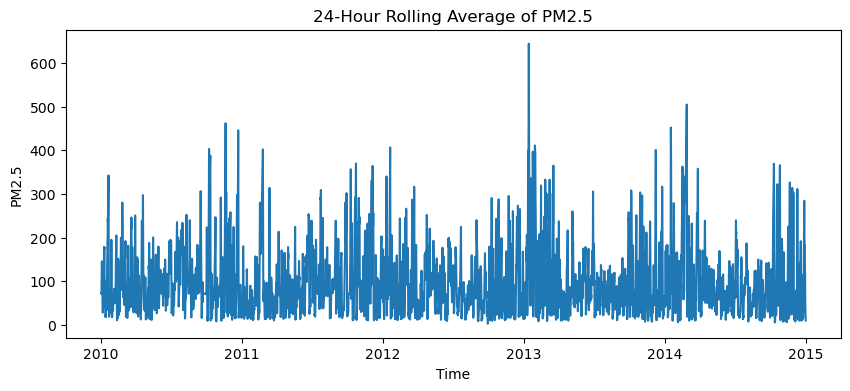

In [30]:
# Rolling Average Trend (Time-Series)
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='datetime', y='pm2.5_24h_avg')
plt.title("24-Hour Rolling Average of PM2.5")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.show()

### Insight:
Rolling averages smooth short-term fluctuations and reveal long-term pollution trends.